In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, Masking
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report)
from xgboost import XGBClassifier
from scipy.stats import randint, uniform

2025-05-10 17:31:04.976911: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-10 17:31:05.264663: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-10 17:31:05.264768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-10 17:31:05.306546: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-10 17:31:05.391698: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.15.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-05-10 17:31:09.061308: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-10 17:31:09.263479: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-10 17:31:09.263823: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
df = pd.read_csv('/home/naq/Downloads/Naq/Data/Full Transactions (1).csv')
df.head()

/tmp/ipykernel_17139/1776434798.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/naq/Downloads/Naq/Data/Full Transactions (1).csv')


,transaction_date,transaction_time,transaction_type,sender_account,receiver_account,merchant_id,bank_channel,transaction_amount,anomaly,transaction_datetime
0,2020-01-01,00:01:04,NAPAS_TRANSFER,4693591281052,21163107764962,100036,970414,100761.0,Normal,2020-01-01 00:01:04
1,2020-01-01,00:03:28,MB_TRANSFER,60911197543566,24961756496672,100039,970460,79270.0,Normal,2020-01-01 00:03:28
2,2020-01-01,00:04:11,VCB_TRANSFER,20890752160161,17721530913303,100075,970418,49428.0,Normal,2020-01-01 00:04:11
3,2020-01-01,00:05:43,MB_TRANSFER,7566469672,17973156424644,100061,970465,143423.0,Normal,2020-01-01 00:05:43
4,2020-01-01,00:06:03,TRANSFER_NAPAS,24961756496672,30882107958,100028,970419,27923.0,Normal,2020-01-01 00:06:03


In [ ]:
incoming_transaction_types = ['NAPAS_TRANSFER', 'CITAD_TRANSFER', 'MB_TRANSFER', 'VCB_TRANSFER']
outgoing_transaction_types = ['TRANSFER_NAPAS', 'TRANSFER_CITAD', 'TRANSFER_MB', 'TRANSFER_VCB']

df['user_account'] = np.where(df['transaction_type'].isin(incoming_transaction_types),
                              df['receiver_account'],
                              df['sender_account'])

df['other_account'] = np.where(df['transaction_type'].isin(incoming_transaction_types),
                               df['sender_account'],
                               df['receiver_account'])
df['transaction_time'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S').dt.time
df['transaction_datetime'] = pd.to_datetime(df['transaction_datetime'])
df['transaction_date'] = pd.to_datetime(df['transaction_date'], errors='coerce')

In [ ]:
def resolve_duplicate_group(group):
    if len(group) == 1:
        return group.iloc[0]  # no need to process

    # Identify row with max transaction amount
    max_idx = group['transaction_amount'].idxmax()
    base = group.loc[max_idx].copy()

    # Sum the transaction amounts
    base['transaction_amount'] = group['transaction_amount'].sum()

    return base

# Step 2: Group by user_account and datetime
grouped = df.groupby(['user_account', 'transaction_datetime'], as_index=False)

# Step 3: Apply resolution function to each group
df = grouped.apply(resolve_duplicate_group)

# Step 4: Reset index if needed (because `groupby().apply()` adds multi-index)
df = df.reset_index(drop=True)

print(f"✅ Deduplicated shape: {df.shape}")

✅ Deduplicated shape: (1329246, 12)


/tmp/ipykernel_17139/2818694811.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = grouped.apply(resolve_duplicate_group)


In [ ]:
# Convert transaction_date to datetime
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Filter only normal transactions
df_filtered = df[df['anomaly'] == 'Normal'].copy()

# Classify transactions correctly
df_filtered['is_income'] = df_filtered['transaction_type'].str.endswith('_TRANSFER')
df_filtered['is_expense'] = df_filtered['transaction_type'].str.startswith('TRANSFER_')

# Extract month-year for aggregation
df_filtered['year_month'] = df_filtered['transaction_date'].dt.to_period('M')

# Compute monthly income and expenses
monthly_income = df_filtered[df_filtered['is_income']].groupby(
    ['receiver_account', 'year_month']
)['transaction_amount'].sum().reset_index().rename(columns={'transaction_amount': 'monthly_income'})

monthly_expense = df_filtered[df_filtered['is_expense']].groupby(
    ['sender_account', 'year_month']
)['transaction_amount'].sum().reset_index().rename(columns={'transaction_amount': 'monthly_expense'})

# Convert year_month to timestamp for merging
monthly_income['year_month'] = monthly_income['year_month'].dt.to_timestamp()
monthly_expense['year_month'] = monthly_expense['year_month'].dt.to_timestamp()

# Merge income and expense into the main DataFrame
df = df.merge(monthly_income, left_on=['receiver_account', df['transaction_date'].dt.to_period('M').dt.to_timestamp()],
              right_on=['receiver_account', 'year_month'], how='left')

df = df.merge(monthly_expense, left_on=['sender_account', df['transaction_date'].dt.to_period('M').dt.to_timestamp()],
              right_on=['sender_account', 'year_month'], how='left')

# Fill NaN values with 0 (assuming no transactions mean zero income/expense)
df['monthly_income'].fillna(0, inplace=True)
df['monthly_expense'].fillna(0, inplace=True)

# Compute rolling 12-month averages and standard deviations
df['rolling_12m_avg_income'] = df.groupby('receiver_account')['monthly_income'].transform(lambda x: x.rolling(12, min_periods=1).mean())
df['rolling_12m_std_income'] = df.groupby('receiver_account')['monthly_income'].transform(lambda x: x.rolling(12, min_periods=1).std())

df['rolling_12m_avg_expense'] = df.groupby('sender_account')['monthly_expense'].transform(lambda x: x.rolling(12, min_periods=1).mean())
df['rolling_12m_std_expense'] = df.groupby('sender_account')['monthly_expense'].transform(lambda x: x.rolling(12, min_periods=1).std())

# Drop redundant column
df.drop(columns=['year_month'], inplace=True)

# Display result
df[['transaction_date', 'receiver_account', 'sender_account', 'transaction_type', 'monthly_income', 'monthly_expense',
    'rolling_12m_avg_income', 'rolling_12m_avg_expense', 'rolling_12m_std_income', 'rolling_12m_std_expense']].head()


/tmp/ipykernel_17139/2082862425.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['monthly_income'].fillna(0, inplace=True)
/tmp/ipykernel_17139/2082862425.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

,transaction_date,receiver_account,sender_account,transaction_type,monthly_income,monthly_expense,rolling_12m_avg_income,rolling_12m_avg_expense,rolling_12m_std_income,rolling_12m_std_expense
0,2020-01-01,1870917112881,856971884,NAPAS_TRANSFER,80783787.0,0.0,80783787.0,0.0,NaN,NaN
1,2020-01-01,1870917112881,93283255692129,MB_TRANSFER,80783787.0,0.0,80783787.0,0.0,0.0,NaN
2,2020-01-01,1870917112881,5128115065,CITAD_TRANSFER,80783787.0,0.0,80783787.0,0.0,0.0,NaN
3,2020-01-01,1870917112881,39880534429566,NAPAS_TRANSFER,80783787.0,0.0,80783787.0,0.0,0.0,NaN
4,2020-01-01,1870917112881,256772531506,MB_TRANSFER,80783787.0,0.0,80783787.0,0.0,0.0,NaN


In [ ]:
# Compute time difference per user (across all days)
df['time_diff'] = df.groupby('user_account')['transaction_date'].diff()

# Convert time difference to seconds
df['time_diff_seconds'] = df['time_diff'].dt.total_seconds()

df.head()

,transaction_date,transaction_time,transaction_type,sender_account,receiver_account,merchant_id,bank_channel,transaction_amount,anomaly,transaction_datetime,...,year_month_x,monthly_income,year_month_y,monthly_expense,rolling_12m_avg_income,rolling_12m_std_income,rolling_12m_avg_expense,rolling_12m_std_expense,time_diff,time_diff_seconds
0,2020-01-01,00:07:06,NAPAS_TRANSFER,856971884,1870917112881,100020,970418,22967.0,Normal,2020-01-01 00:07:06,...,2020-01-01,80783787.0,NaT,0.0,80783787.0,NaN,0.0,NaN,NaT,NaN
1,2020-01-01,02:15:20,MB_TRANSFER,93283255692129,1870917112881,100044,970405,74344.0,Normal,2020-01-01 02:15:20,...,2020-01-01,80783787.0,NaT,0.0,80783787.0,0.0,0.0,NaN,0 days,0.0
2,2020-01-01,02:22:55,CITAD_TRANSFER,5128115065,1870917112881,100032,970424,33617.0,Normal,2020-01-01 02:22:55,...,2020-01-01,80783787.0,NaT,0.0,80783787.0,0.0,0.0,NaN,0 days,0.0
3,2020-01-01,02:52:25,NAPAS_TRANSFER,39880534429566,1870917112881,100046,970431,23930.0,Normal,2020-01-01 02:52:25,...,2020-01-01,80783787.0,NaT,0.0,80783787.0,0.0,0.0,NaN,0 days,0.0
4,2020-01-01,02:57:25,MB_TRANSFER,256772531506,1870917112881,100001,970434,22829.0,Normal,2020-01-01 02:57:25,...,2020-01-01,80783787.0,NaT,0.0,80783787.0,0.0,0.0,NaN,0 days,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329246 entries, 0 to 1329245
Data columns (total 22 columns):
 #   Column                   Non-Null Count    Dtype          
---  ------                   --------------    -----          
 0   transaction_date         1329246 non-null  datetime64[ns] 
 1   transaction_time         1329246 non-null  object         
 2   transaction_type         1329246 non-null  object         
 3   sender_account           1329246 non-null  int64          
 4   receiver_account         1329246 non-null  int64          
 5   merchant_id              1329246 non-null  object         
 6   bank_channel             1329246 non-null  int64          
 7   transaction_amount       1329246 non-null  float64        
 8   anomaly                  1329246 non-null  object         
 9   transaction_datetime     1329246 non-null  datetime64[ns] 
 10  user_account             1329246 non-null  int64          
 11  other_account            1329246 non-null  int64  

In [ ]:
# Count transactions within the last 3 minutes
def count_transactions_last_3min(df):
    df = df.copy()
    df['transaction_timestamp'] = df['transaction_date'].astype('int64') // 10**9  # Convert datetime to seconds
    df = df.sort_values(by=['sender_account', 'transaction_timestamp'])  # Ensure sorting

    transaction_counts = np.zeros(len(df), dtype=int)

    grouped = df.groupby('user_account')

    for user, user_df in grouped:
        timestamps = user_df['transaction_timestamp'].values
        count_array = np.searchsorted(timestamps, timestamps - 180, side='left')
        transaction_counts[user_df.index] = np.arange(len(timestamps)) - count_array + 1

    df['transaction_count_last_3min'] = transaction_counts
    return df

df = count_transactions_last_3min(df)

In [ ]:
def generate_transaction_level_features(original_df):
    df = original_df.copy()
    df.sort_values(by=['user_account', 'transaction_datetime'], inplace=True)

    df['month'] = df['transaction_date'].dt.month
    df['day_of_year'] = df['transaction_date'].dt.dayofyear
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_year_scaled'] = df['day_of_year'] / 365.0

    # Extract datetime features
    df['hour'] = df['transaction_datetime'].dt.hour
    df['day'] = df['transaction_datetime'].dt.day
    df['weekday'] = df['transaction_datetime'].dt.weekday

    # Derive transaction type and bank code features
    df['is_credit'] = df['transaction_type'].apply(lambda x: 1 if x.endswith('_TRANSFER') else 0)

    df['transaction_amount_log'] = np.log1p(df['transaction_amount'])

    df['amount_near_threshold_flag'] = df['transaction_amount'].apply(
        lambda x: 1 if (9_800_000 <= x <= 10_000_000 or 480_000_000 <= x <= 499_000_000) else 0
    )

    df['txn_gap_days'] = df.groupby('user_account')['transaction_datetime'].diff().dt.days.fillna(9999)
    df['is_first_txn_after_inactivity'] = (df['txn_gap_days'] > 30).astype(int)

    return df
df = generate_transaction_level_features(df)

In [ ]:
def flag_similar_txns_last_year(df):
    df = df.copy()
    df['datetime'] = pd.to_datetime(df['transaction_date'])
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month

    df['similar_income_txn_in_last_12m'] = 0
    df['similar_outflow_txn_in_last_12m'] = 0

    grouped = df.groupby('user_account')

    for user, group in grouped:
        group = group.sort_values('datetime')
        idx_map = group.index

        for i, row in group.iterrows():
            current_dt = row['datetime']
            current_amt = row['transaction_amount']
            current_month = row['month']
            current_year = row['year']

            min_amt = 0.8 * current_amt
            max_amt = 1.2 * current_amt
            same_months = [(current_month - 1) % 12 or 12, current_month, (current_month + 1) % 12 or 12]

            mask = (
                (group['datetime'] < current_dt) &
                (group['datetime'] >= current_dt - pd.DateOffset(years=1)) &
                (group['month'].isin(same_months)) &
                (group['transaction_amount'] >= min_amt) &
                (group['transaction_amount'] <= max_amt)
            )

            inflow_match = mask & (group['is_credit'] == 1)
            outflow_match = mask & (group['is_credit'] == 0)

            df.at[i, 'similar_income_txn_in_last_12m'] = int(inflow_match.any())
            df.at[i, 'similar_outflow_txn_in_last_12m'] = int(outflow_match.any())

    return df

df = flag_similar_txns_last_year(df)

In [ ]:
def generate_rolling_features(df, days=30):
    df = df.sort_values(['user_account', 'transaction_datetime']).copy()

    df['rolling_30d_inflow_total'] = 0.0
    df['rolling_30d_outflow_total'] = 0.0
    df['rolling_avg_txn_amount_30d'] = 0.0
    df['unusual_merchant_30d'] = 0

    for user, group in df.groupby('user_account'):
        group = group.reset_index()
        last_seen_merchant = {}
        inflow_totals, outflow_totals, avg_amounts, merchant_flags = [], [], [], []

        for i, row in group.iterrows():
            current_time = row['transaction_datetime']
            current_amt = row['transaction_amount']
            is_credit = row['is_credit']
            merchant = row['merchant_id']

            # Get past 30-day transactions (before current)
            past_txns = group[
                (group['transaction_datetime'] < current_time) &
                (group['transaction_datetime'] >= current_time - pd.Timedelta(days=days))
            ]

            past_inflow = past_txns[past_txns['is_credit'] == 1]['transaction_amount'].sum()
            past_outflow = past_txns[past_txns['is_credit'] == 0]['transaction_amount'].sum()
            avg_amt = past_txns['transaction_amount'].mean() if not past_txns.empty else 0.0

            # Add current transaction into inflow/outflow based on its flow
            inflow_total = past_inflow + current_amt if is_credit == 1 else past_inflow
            outflow_total = past_outflow + current_amt if is_credit == 0 else past_outflow

            # Unusual merchant check
            is_unusual = 1
            if merchant in last_seen_merchant:
                if (current_time - last_seen_merchant[merchant]).days <= days:
                    is_unusual = 0
            last_seen_merchant[merchant] = current_time

            # Collect
            inflow_totals.append(inflow_total)
            outflow_totals.append(outflow_total)
            avg_amounts.append(avg_amt)
            merchant_flags.append(is_unusual)

        # Assign results
        df.loc[group['index'], 'rolling_30d_inflow_total'] = inflow_totals
        df.loc[group['index'], 'rolling_30d_outflow_total'] = outflow_totals
        df.loc[group['index'], 'rolling_avg_txn_amount_30d'] = avg_amounts
        df.loc[group['index'], 'unusual_merchant_30d'] = merchant_flags

    return df

df = generate_rolling_features(df)

In [ ]:
def generate_monthly_stats(last_df):
    df = last_df.copy()
    df['transaction_date'] = pd.to_datetime(df['transaction_date'])
    df['year_month'] = df['transaction_date'].dt.to_period('M')

    # Step 1: Aggregate monthly inflow and outflow
    monthly_income = (
        df[df['is_credit'] == 1]
        .groupby(['user_account', 'year_month'])['transaction_amount']
        .sum()
        .rename('monthly_inflow')
        .reset_index()
    )

    monthly_outflow = (
        df[df['is_credit'] == 0]
        .groupby(['user_account', 'year_month'])['transaction_amount']
        .sum()
        .rename('monthly_outflow')
        .reset_index()
    )

    monthly = pd.merge(monthly_income, monthly_outflow, on=['user_account', 'year_month'], how='outer').fillna(0)

    # Step 2: Compute rolling 12-month mean, std, z-score, spike flags, and recurrence
    for col in ['monthly_inflow', 'monthly_outflow']:
        mean_col = f'{col}_mean_12m'
        std_col = f'{col}_std_12m'
        z_col = f'{col}_zscore_12m'
        spike_flag = f'{col}_spike_flag'
        sim_flag = f'similar_{col}_spike_last_12m'

        # Rolling mean and std (excluding current month)
        monthly[mean_col] = (
            monthly.groupby('user_account')[col]
            .transform(lambda x: x.shift(1).rolling(12, min_periods=3).mean())
        )
        monthly[std_col] = (
            monthly.groupby('user_account')[col]
            .transform(lambda x: x.shift(1).rolling(12, min_periods=3).std())
        )

        # Z-score and spike flag
        monthly[z_col] = (monthly[col] - monthly[mean_col]) / (monthly[std_col] + 1e-6)
        monthly[spike_flag] = (monthly[z_col] > 2).astype(int)

        # Similar spike occurred in last 12 months?
        def check_spike(g):
            spikes = (g[z_col] > 2).astype(int)
            return spikes.shift(1).rolling(12, min_periods=3).sum().fillna(0).gt(0).astype(int)

        monthly[sim_flag] = (
            monthly.groupby('user_account')
            .apply(check_spike)
            .reset_index(level=0, drop=True)
        )

    # Step 3: Rename columns for clarity
    monthly.rename(columns={
        'monthly_inflow_mean_12m': 'monthly_avg_income_last_12m',
        'monthly_outflow_mean_12m': 'monthly_avg_outflow_last_12m',
        'monthly_inflow_zscore_12m': 'income_zscore_12m',
        'monthly_outflow_zscore_12m': 'outflow_zscore_12m',
        'monthly_inflow_spike_flag': 'income_spike_this_month',
        'monthly_outflow_spike_flag': 'outflow_spike_this_month',
        'similar_monthly_inflow_spike_last_12m': 'similar_income_spike_in_last_12m',
        'similar_monthly_outflow_spike_last_12m': 'similar_outflow_spike_in_last_12m'
    }, inplace=True)

    # Step 4: Compute current-to-average ratios
    monthly['current_income_to_12m_avg_ratio'] = (
        monthly['monthly_inflow'] / (monthly['monthly_avg_income_last_12m'] + 1e-6)
    )
    monthly['current_outflow_to_12m_avg_ratio'] = (
        monthly['monthly_outflow'] / (monthly['monthly_avg_outflow_last_12m'] + 1e-6)
    )

    return monthly

monthly_stats = generate_monthly_stats(df)

/tmp/ipykernel_461420/2448681518.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(check_spike)
/tmp/ipykernel_461420/2448681518.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(check_spike)


In [ ]:
df['year_month'] = df['transaction_date'].dt.to_period('M')
full_features = df.merge(monthly_stats, on=['user_account', 'year_month'], how='left')

In [ ]:
# Add binary label
full_features['label'] = (full_features['anomaly'] != 'Normal').astype(int)
full_features['location_flag'] = np.where(full_features['anomaly'] == 'Unusual Merchant Activity', 1, 0)

In [ ]:
full_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329246 entries, 0 to 1329245
Data columns (total 62 columns):
 #   Column                             Non-Null Count    Dtype          
---  ------                             --------------    -----          
 0   transaction_date                   1329246 non-null  datetime64[ns] 
 1   transaction_time                   1329246 non-null  object         
 2   transaction_type                   1329246 non-null  object         
 3   sender_account                     1329246 non-null  int64          
 4   receiver_account                   1329246 non-null  int64          
 5   merchant_id                        1329246 non-null  object         
 6   bank_channel                       1329246 non-null  int64          
 7   transaction_amount                 1329246 non-null  float64        
 8   anomaly                            1329246 non-null  object         
 9   transaction_datetime               1329246 non-null  datetime64[ns] 

Data Processing + Feature Engineering

In [ ]:
df = full_features.copy()
features_for_sequence = [
    'transaction_amount', 'monthly_income', 'monthly_expense',
    'rolling_12m_avg_expense', 'time_diff_seconds', 'transaction_count_last_3min'
]
features_for_tabular = [
    'transaction_amount',
    'amount_near_threshold_flag', 'is_first_txn_after_inactivity',
    'rolling_30d_inflow_total', 'rolling_30d_outflow_total',
    'rolling_avg_txn_amount_30d', 'unusual_merchant_30d',
    'month_sin', 'month_cos', 'current_income_to_12m_avg_ratio', 'current_outflow_to_12m_avg_ratio',
    'similar_outflow_spike_in_last_12m', 'similar_income_spike_in_last_12m',
    'income_zscore_12m', 'outflow_zscore_12m', 'location_flag'
]

LABEL_COL = 'label'
# 2. Handle missing values
df[features_for_sequence] = df[features_for_sequence].fillna(0)
df[features_for_tabular] = df[features_for_tabular].fillna(0)

# 3. Scale sequence + tabular features
scaler = MinMaxScaler()
df[features_for_sequence] = scaler.fit_transform(df[features_for_sequence])
df[features_for_tabular] = scaler.fit_transform(df[features_for_tabular])


In [ ]:
# 4. Create sequences
def create_sequences(data, sequence_length=12):
    sequences, labels, tabular_inputs, indexes = [], [], [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length][features_for_sequence].values
        tab = data.iloc[i + sequence_length][features_for_tabular].values
        label = data.iloc[i + sequence_length]['label']  # assuming you already created a 'label' column
        sequences.append(seq)
        tabular_inputs.append(tab)
        labels.append(label)
        indexes.append(data.index[i + sequence_length])
    return np.array(sequences), np.array(labels), np.array(tabular_inputs), np.array(indexes)

# 5. Apply
sequence_length = 12
X_seq, y, X_tab, meta = create_sequences(df, sequence_length=sequence_length)

print(f"✅ Sequence shape: {X_seq.shape}")
print(f"✅ Tabular shape : {X_tab.shape}")
print(f"✅ Labels shape  : {y.shape}")

✅ Sequence shape: (1329234, 12, 6)
✅ Tabular shape : (1329234, 16)
✅ Labels shape  : (1329234,)


In [ ]:
from sklearn.model_selection import train_test_split

X_seq_train, X_seq_test, X_tab_train, X_tab_test, y_train, y_test, meta_train, meta_test = train_test_split(
    X_seq, X_tab, y, meta, test_size=0.2, random_state=42, stratify=y
)

Hybrid Model

In [ ]:
# ===== Step 2: BiLSTM Model (for embeddings) =====
def build_bilstm_model(seq_length, num_features, lstm_units=64):
    seq_input = Input(shape=(seq_length, num_features))
    x = Masking(mask_value=0.0)(seq_input)
    x = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    x = Dropout(0.2)(x)
    x = Bidirectional(LSTM(lstm_units // 2, return_sequences=False))(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)
    return Model(inputs=seq_input, outputs=x)

bilstm_model = build_bilstm_model(sequence_length, len(features_for_sequence))
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("bilstm_best.keras", monitor='val_loss', save_best_only=True)

# Train BiLSTM
bilstm_model.fit(
    X_seq_train, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=64,
    callbacks=[early_stop, checkpoint],
    verbose=2
)

2025-05-05 17:59:07.925084: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-05 17:59:07.925273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-05 17:59:07.925336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/5


2025-05-05 17:59:14.032796: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_38/output/_24'
2025-05-05 17:59:14.401853: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2025-05-05 17:59:15.362760: I external/local_xla/xla/service/service.cc:168] XLA service 0x7aa50cd73b30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-05 17:59

13293/13293 - 247s - loss: 0.0183 - val_loss: 0.0131 - 247s/epoch - 19ms/step
Epoch 2/5
13293/13293 - 265s - loss: 0.0135 - val_loss: 0.0119 - 265s/epoch - 20ms/step
Epoch 3/5
13293/13293 - 262s - loss: 0.0127 - val_loss: 0.0112 - 262s/epoch - 20ms/step
Epoch 4/5
13293/13293 - 262s - loss: 0.0123 - val_loss: 0.0109 - 262s/epoch - 20ms/step
Epoch 5/5
13293/13293 - 181s - loss: 0.0122 - val_loss: 0.0109 - 181s/epoch - 14ms/step


In [ ]:
# --- 6. Extract Embeddings ---
embedding_model = Model(inputs=bilstm_model.input, outputs=bilstm_model.layers[-2].output)
train_embeddings = embedding_model.predict(X_seq_train, batch_size=128)
test_embeddings = embedding_model.predict(X_seq_test, batch_size=128)

X_hybrid_train = np.concatenate([train_embeddings, X_tab_train], axis=1)
X_hybrid_test = np.concatenate([test_embeddings, X_tab_test], axis=1)

2077/2077 [==============================] - 11s 5ms/step


In [ ]:
print(f"Imbalance rate = {(y_train == 0).sum() / (y_train == 1).sum()}")

Imbalance rate = 224.96408839779005


In [ ]:
# --- 7. Hyperparameter Tuning for XGBoost ---
param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3),
    'min_child_weight': randint(1, 10)
}

xgb_clf = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    tree_method='gpu_hist',
    predictor='gpu_predictor'
)

random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    scoring='roc_auc',
    n_iter=30,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

In [ ]:
random_search.fit(X_hybrid_train, y_train)
best_params = random_search.best_params_
print("Best parameters found: ", best_params)
best_xgb = random_search.best_estimator_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:30:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:30:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:30:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.20014286128198325, max_depth=5, min_child_weight=8, n_estimators=288, subsample=0.879055047383946; total time=   5.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:30:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:30:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:30:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.20014286128198325, max_depth=5, min_child_weight=8, n_estimators=288, subsample=0.879055047383946; total time=   5.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:31:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:31:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:31:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8123620356542087, learning_rate=0.20014286128198325, max_depth=5, min_child_weight=8, n_estimators=288, subsample=0.879055047383946; total time=   5.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:31:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:31:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:31:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8337498258560773, learning_rate=0.02999498316360058, max_depth=5, min_child_weight=8, n_estimators=199, subsample=0.7428600453765822; total time=   5.1s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:31:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:31:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:32:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8337498258560773, learning_rate=0.02999498316360058, max_depth=5, min_child_weight=8, n_estimators=199, subsample=0.7428600453765822; total time=   5.2s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:32:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:32:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:32:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8337498258560773, learning_rate=0.02999498316360058, max_depth=5, min_child_weight=8, n_estimators=199, subsample=0.7428600453765822; total time=   5.2s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:32:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:32:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:32:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8952665418846558, learning_rate=0.021282315805420053, max_depth=6, min_child_weight=6, n_estimators=291, subsample=0.9976634677873653; total time=   5.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:33:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:33:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:33:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8952665418846558, learning_rate=0.021282315805420053, max_depth=6, min_child_weight=6, n_estimators=291, subsample=0.9976634677873653; total time=   5.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:33:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:33:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:33:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8952665418846558, learning_rate=0.021282315805420053, max_depth=6, min_child_weight=6, n_estimators=291, subsample=0.9976634677873653; total time=   5.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:34:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:34:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:34:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8852444528883149, learning_rate=0.1323306320976562, max_depth=7, min_child_weight=9, n_estimators=148, subsample=0.8574323980775167; total time=   5.1s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:34:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:34:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:34

[CV] END colsample_bytree=0.8852444528883149, learning_rate=0.1323306320976562, max_depth=7, min_child_weight=9, n_estimators=148, subsample=0.8574323980775167; total time=   5.2s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:35:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:35:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:35:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8852444528883149, learning_rate=0.1323306320976562, max_depth=7, min_child_weight=9, n_estimators=148, subsample=0.8574323980775167; total time=   5.1s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:35:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:35:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:35:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8199582915145766, learning_rate=0.019333132642723086, max_depth=6, min_child_weight=3, n_estimators=154, subsample=0.9949692657420364; total time=   4.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:36:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:36:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:36:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8199582915145766, learning_rate=0.019333132642723086, max_depth=6, min_child_weight=3, n_estimators=154, subsample=0.9949692657420364; total time=   5.0s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:36:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:36:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:36:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8199582915145766, learning_rate=0.019333132642723086, max_depth=6, min_child_weight=3, n_estimators=154, subsample=0.9949692657420364; total time=   4.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:37:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:37:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:37:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8400288679743939, learning_rate=0.18198808134726413, max_depth=9, min_child_weight=5, n_estimators=266, subsample=0.7039794883479599; total time=   6.2s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:37:49] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:37:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:37:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8400288679743939, learning_rate=0.18198808134726413, max_depth=9, min_child_weight=5, n_estimators=266, subsample=0.7039794883479599; total time=   6.3s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:38:18] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:38:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:38:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8400288679743939, learning_rate=0.18198808134726413, max_depth=9, min_child_weight=5, n_estimators=266, subsample=0.7039794883479599; total time=   6.3s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:38:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:38:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:38:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9826605267054558, learning_rate=0.12265764356910785, max_depth=4, min_child_weight=9, n_estimators=152, subsample=0.7692681476866446; total time=   4.6s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:39:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:39:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:39:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9826605267054558, learning_rate=0.12265764356910785, max_depth=4, min_child_weight=9, n_estimators=152, subsample=0.7692681476866446; total time=   4.6s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:39:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:39:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:39:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9826605267054558, learning_rate=0.12265764356910785, max_depth=4, min_child_weight=9, n_estimators=152, subsample=0.7692681476866446; total time=   4.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:40:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:40:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:40:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7723076398078035, learning_rate=0.14665270376509165, max_depth=6, min_child_weight=8, n_estimators=134, subsample=0.9727961206236346; total time=   4.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:40:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:40:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:40:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7723076398078035, learning_rate=0.14665270376509165, max_depth=6, min_child_weight=8, n_estimators=134, subsample=0.9727961206236346; total time=   4.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:41:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:41:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:41:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7723076398078035, learning_rate=0.14665270376509165, max_depth=6, min_child_weight=8, n_estimators=134, subsample=0.9727961206236346; total time=   4.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:41:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:41:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:41:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.777633994480005, learning_rate=0.1425044568707964, max_depth=4, min_child_weight=6, n_estimators=153, subsample=0.8640130838029838; total time=   4.6s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:42:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:42:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:42:04] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.777633994480005, learning_rate=0.1425044568707964, max_depth=4, min_child_weight=6, n_estimators=153, subsample=0.8640130838029838; total time=   4.6s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:42:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:42:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:42:32] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.777633994480005, learning_rate=0.1425044568707964, max_depth=4, min_child_weight=6, n_estimators=153, subsample=0.8640130838029838; total time=   4.6s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:42:59] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:43:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7554563366576581, learning_rate=0.20391692555291174, max_depth=4, min_child_weight=2, n_estimators=301, subsample=0.9684482051282945; total time=   5.5s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:43:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:43:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:43:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7554563366576581, learning_rate=0.20391692555291174, max_depth=4, min_child_weight=2, n_estimators=301, subsample=0.9684482051282945; total time=   5.4s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:43:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:43:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:43:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7554563366576581, learning_rate=0.20391692555291174, max_depth=4, min_child_weight=2, n_estimators=301, subsample=0.9684482051282945; total time=   5.4s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:44:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:44:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:44:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8793699936433255, learning_rate=0.19437484700462337, max_depth=8, min_child_weight=7, n_estimators=351, subsample=0.7135681866731614; total time=   6.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:44:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:44:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:44:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8793699936433255, learning_rate=0.19437484700462337, max_depth=8, min_child_weight=7, n_estimators=351, subsample=0.7135681866731614; total time=   6.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:45:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:45:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:45:24] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8793699936433255, learning_rate=0.19437484700462337, max_depth=8, min_child_weight=7, n_estimators=351, subsample=0.7135681866731614; total time=   6.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:45:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:45:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:45:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7975990992289792, learning_rate=0.0877354579378964, max_depth=4, min_child_weight=5, n_estimators=379, subsample=0.8070259980080767; total time=   6.0s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:46:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:46:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:46:22] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7975990992289792, learning_rate=0.0877354579378964, max_depth=4, min_child_weight=5, n_estimators=379, subsample=0.8070259980080767; total time=   5.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:46:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:46:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:46:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7975990992289792, learning_rate=0.0877354579378964, max_depth=4, min_child_weight=5, n_estimators=379, subsample=0.8070259980080767; total time=   5.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:47:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:47:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:47:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7842803529062142, learning_rate=0.1185392166316497, max_depth=3, min_child_weight=1, n_estimators=108, subsample=0.9316734307889971; total time=   4.3s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:47:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:47:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:47:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7842803529062142, learning_rate=0.1185392166316497, max_depth=3, min_child_weight=1, n_estimators=108, subsample=0.9316734307889971; total time=   4.3s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:48:12] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:48:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:48:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7842803529062142, learning_rate=0.1185392166316497, max_depth=3, min_child_weight=1, n_estimators=108, subsample=0.9316734307889971; total time=   4.2s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:48:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:48:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:48:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7596147044602517, learning_rate=0.01110442342472048, max_depth=5, min_child_weight=3, n_estimators=180, subsample=0.9134025858245949; total time=   4.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:49:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:49:07] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:49:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7596147044602517, learning_rate=0.01110442342472048, max_depth=5, min_child_weight=3, n_estimators=180, subsample=0.9134025858245949; total time=   4.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:49:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:49:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:49:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7596147044602517, learning_rate=0.01110442342472048, max_depth=5, min_child_weight=3, n_estimators=180, subsample=0.9134025858245949; total time=   4.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:50:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:50:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:50:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9370526621593617, learning_rate=0.1311919949562023, max_depth=4, min_child_weight=7, n_estimators=140, subsample=0.9744879026631341; total time=   4.5s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:50:34] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:50:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:50:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9370526621593617, learning_rate=0.1311919949562023, max_depth=4, min_child_weight=7, n_estimators=140, subsample=0.9744879026631341; total time=   4.6s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:51:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:51:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:51:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9370526621593617, learning_rate=0.1311919949562023, max_depth=4, min_child_weight=7, n_estimators=140, subsample=0.9744879026631341; total time=   4.6s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:51:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:51:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:51:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9550115733369398, learning_rate=0.09989013482764068, max_depth=3, min_child_weight=7, n_estimators=161, subsample=0.7975549966080241; total time=   4.5s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:51:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:51:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:51:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9550115733369398, learning_rate=0.09989013482764068, max_depth=3, min_child_weight=7, n_estimators=161, subsample=0.7975549966080241; total time=   4.6s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:52:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:52:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:52:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9550115733369398, learning_rate=0.09989013482764068, max_depth=3, min_child_weight=7, n_estimators=161, subsample=0.7975549966080241; total time=   4.5s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:52:55] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:52:55] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:52:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9188818535014192, learning_rate=0.13751149427104264, max_depth=5, min_child_weight=3, n_estimators=326, subsample=0.7358782737814905; total time=   6.0s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:53:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:53:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:53:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9188818535014192, learning_rate=0.13751149427104264, max_depth=5, min_child_weight=3, n_estimators=326, subsample=0.7358782737814905; total time=   5.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:53:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:53:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:53:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9188818535014192, learning_rate=0.13751149427104264, max_depth=5, min_child_weight=3, n_estimators=326, subsample=0.7358782737814905; total time=   5.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:54:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:54:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:54:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9139734361668984, learning_rate=0.1621570097233795, max_depth=4, min_child_weight=7, n_estimators=354, subsample=0.7768204968283972; total time=   5.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:54:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:54:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:54:50] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9139734361668984, learning_rate=0.1621570097233795, max_depth=4, min_child_weight=7, n_estimators=354, subsample=0.7768204968283972; total time=   5.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:55:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:55:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:55:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9139734361668984, learning_rate=0.1621570097233795, max_depth=4, min_child_weight=7, n_estimators=354, subsample=0.7768204968283972; total time=   5.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:55:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:55:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:55:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7121300768615294, learning_rate=0.15213257793715748, max_depth=4, min_child_weight=3, n_estimators=162, subsample=0.9687290787020557; total time=   4.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:56:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:56:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:56:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7121300768615294, learning_rate=0.15213257793715748, max_depth=4, min_child_weight=3, n_estimators=162, subsample=0.9687290787020557; total time=   4.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:56:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:56:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:56:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7121300768615294, learning_rate=0.15213257793715748, max_depth=4, min_child_weight=3, n_estimators=162, subsample=0.9687290787020557; total time=   4.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:57:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:57:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:57:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8426110669546335, learning_rate=0.12265511439527674, max_depth=6, min_child_weight=5, n_estimators=330, subsample=0.8231148769106889; total time=   6.3s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:57:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:57:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:57:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8426110669546335, learning_rate=0.12265511439527674, max_depth=6, min_child_weight=5, n_estimators=330, subsample=0.8231148769106889; total time=   6.3s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:58:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:58:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:58:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8426110669546335, learning_rate=0.12265511439527674, max_depth=6, min_child_weight=5, n_estimators=330, subsample=0.8231148769106889; total time=   6.2s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:58:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:58:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:58:43] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9266653415629146, learning_rate=0.0557596330983245, max_depth=9, min_child_weight=3, n_estimators=185, subsample=0.9641403517045772; total time=   5.3s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:59:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:59:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:59:10] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9266653415629146, learning_rate=0.0557596330983245, max_depth=9, min_child_weight=3, n_estimators=185, subsample=0.9641403517045772; total time=   5.4s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:59:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [18:59:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [18:59:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9266653415629146, learning_rate=0.0557596330983245, max_depth=9, min_child_weight=3, n_estimators=185, subsample=0.9641403517045772; total time=   5.5s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:00:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:00:08] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:00:11] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8873062144401379, learning_rate=0.06912673716754279, max_depth=7, min_child_weight=6, n_estimators=383, subsample=0.9411016230697342; total time=   6.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:00:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:00:37] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:00:40] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8873062144401379, learning_rate=0.06912673716754279, max_depth=7, min_child_weight=6, n_estimators=383, subsample=0.9411016230697342; total time=   6.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:01:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:01:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:01:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8873062144401379, learning_rate=0.06912673716754279, max_depth=7, min_child_weight=6, n_estimators=383, subsample=0.9411016230697342; total time=   6.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:01:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:01:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:01:37] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7559710176658108, learning_rate=0.18851179969799559, max_depth=5, min_child_weight=7, n_estimators=330, subsample=0.9720485324637261; total time=   5.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:02:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:02:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:02:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7559710176658108, learning_rate=0.18851179969799559, max_depth=5, min_child_weight=7, n_estimators=330, subsample=0.9720485324637261; total time=   5.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:02:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:02:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:02:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7559710176658108, learning_rate=0.18851179969799559, max_depth=5, min_child_weight=7, n_estimators=330, subsample=0.9720485324637261; total time=   5.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:03:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:03:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:03:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7816396748153905, learning_rate=0.13953802410827248, max_depth=3, min_child_weight=4, n_estimators=332, subsample=0.7914343774474086; total time=   5.4s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:03:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:03:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:03:31] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7816396748153905, learning_rate=0.13953802410827248, max_depth=3, min_child_weight=4, n_estimators=332, subsample=0.7914343774474086; total time=   5.4s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:03:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:03:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:03:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7816396748153905, learning_rate=0.13953802410827248, max_depth=3, min_child_weight=4, n_estimators=332, subsample=0.7914343774474086; total time=   5.5s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:04:26] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:04:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:04:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7493967559428825, learning_rate=0.11681788387508839, max_depth=8, min_child_weight=5, n_estimators=324, subsample=0.7359596102001048; total time=   7.0s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:04:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:04:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:04:59] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7493967559428825, learning_rate=0.11681788387508839, max_depth=8, min_child_weight=5, n_estimators=324, subsample=0.7359596102001048; total time=   6.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:05:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:05:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:05:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7493967559428825, learning_rate=0.11681788387508839, max_depth=8, min_child_weight=5, n_estimators=324, subsample=0.7359596102001048; total time=   6.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:05:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:05:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:06:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8012845514210883, learning_rate=0.19858194078250385, max_depth=8, min_child_weight=8, n_estimators=332, subsample=0.8211508513174122; total time=   6.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:06:28] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:06:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:06:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8012845514210883, learning_rate=0.19858194078250385, max_depth=8, min_child_weight=8, n_estimators=332, subsample=0.8211508513174122; total time=   6.6s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:06:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:06:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:07:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.8012845514210883, learning_rate=0.19858194078250385, max_depth=8, min_child_weight=8, n_estimators=332, subsample=0.8211508513174122; total time=   6.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:07:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:07:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:07:27] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7194676741326944, learning_rate=0.06078308278686894, max_depth=6, min_child_weight=7, n_estimators=212, subsample=0.74442607898602; total time=   5.3s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:07:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:07:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:07:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7194676741326944, learning_rate=0.06078308278686894, max_depth=6, min_child_weight=7, n_estimators=212, subsample=0.74442607898602; total time=   5.3s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:08:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:08:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:08:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7194676741326944, learning_rate=0.06078308278686894, max_depth=6, min_child_weight=7, n_estimators=212, subsample=0.74442607898602; total time=   5.4s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:08:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:08:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:08:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9993221455146826, learning_rate=0.063356202855057, max_depth=4, min_child_weight=2, n_estimators=319, subsample=0.7154436253749967; total time=   5.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:09:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:09:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:09:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9993221455146826, learning_rate=0.063356202855057, max_depth=4, min_child_weight=2, n_estimators=319, subsample=0.7154436253749967; total time=   5.6s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:09:52] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:09:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:09:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9993221455146826, learning_rate=0.063356202855057, max_depth=4, min_child_weight=2, n_estimators=319, subsample=0.7154436253749967; total time=   5.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:10:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:10:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:10:20] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7835939392709834, learning_rate=0.19165317719333075, max_depth=5, min_child_weight=2, n_estimators=152, subsample=0.8468358280832688; total time=   4.7s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:10:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:10:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:10:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7835939392709834, learning_rate=0.19165317719333075, max_depth=5, min_child_weight=2, n_estimators=152, subsample=0.8468358280832688; total time=   4.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:11:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:11:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:11:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.7835939392709834, learning_rate=0.19165317719333075, max_depth=5, min_child_weight=2, n_estimators=152, subsample=0.8468358280832688; total time=   4.8s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:11:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:11:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:11:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9956951362331802, learning_rate=0.058411054302300085, max_depth=6, min_child_weight=7, n_estimators=302, subsample=0.8108963368184213; total time=   5.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:12:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:12:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:12:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9956951362331802, learning_rate=0.058411054302300085, max_depth=6, min_child_weight=7, n_estimators=302, subsample=0.8108963368184213; total time=   5.9s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:12:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:12:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [19:12:44] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

[CV] END colsample_bytree=0.9956951362331802, learning_rate=0.058411054302300085, max_depth=6, min_child_weight=7, n_estimators=302, subsample=0.8108963368184213; total time=   6.0s


/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:12:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [19:12:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters found:  {'colsample_bytree': 0.8873062144401379, 'learning_rate': 0.06912673716754279, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 383, 'subsample': 0.9411016230697342}


In [ ]:
# --- 8. Final Train ---
best_xgb.fit(X_hybrid_train, y_train)

# --- 9. Predict ---
y_test_hybrid_pred = best_xgb.predict(X_hybrid_test)
y_test_hybrid_prob = best_xgb.predict_proba(X_hybrid_test)[:, 1]

/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:55:47] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [20:55:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/xgboost/core.py:2676: UserWarning: [20:55:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features(

In [ ]:
print("✅ Best XGBoost Parameters after tuning:")
print(best_xgb.get_params())

✅ Best XGBoost Parameters after tuning:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.7121300768615294, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.15213257793715748, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': 3, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 162, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': 224.96408839779005, 'subsample': 0.9687290787020557, 'tree_method': 'gpu_hist', 'validate_parameters': Non

In [ ]:
# --- 10. Evaluation Function ---
import matplotlib.pyplot as plt
def evaluate_model(y_true, y_pred, y_prob, name="Set"):
    print(f"\n📊 {name} Metrics:")
    print(f"Accuracy     : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision    : {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall       : {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score     : {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_prob):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_vals, precision_vals)
    plt.figure(figsize=(10, 5))
    plt.plot(recall_vals, precision_vals, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()


evaluate_model(y_test, y_test_hybrid_pred, y_test_hybrid_prob, name="Test")

# --- 11. Save Models ---
bilstm_model.save('final_bilstm_model.keras')
best_xgb.save_model('final_xgb_model.json')

NameError: name 'y_test_hybrid_pred' is not defined

Only LSTM

In [ ]:
# Feature selection
features = ['transaction_amount', 'monthly_income', 'monthly_expense', 'rolling_12m_avg_income', 'rolling_12m_std_income', 'rolling_12m_avg_expense', 'time_diff_seconds','transaction_count_last_3min']
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])
# Prepare sequences for LSTM
def create_sequences(data, sequence_length=12):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length][features].values
        label = 1 if data.iloc[i + sequence_length]['anomaly'] != 'Normal' else 0
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 12
X, y = create_sequences(df)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, average_precision_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [ ]:
# Flatten sequences for SMOTE
X_flat = X_seq.reshape((X_seq.shape[0], -1))

X_flat = np.nan_to_num(X_flat, nan=0)
# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_flat, y)

# Reshape back to LSTM shape
X_resampled = X_resampled.reshape((X_resampled.shape[0], sequence_length, len(features_for_sequence)))

# Split resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Build BiLSTM Model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True), input_shape=(sequence_length, len(features_for_sequence))),
    Dropout(0.2),
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.2),
    LSTM(16, return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/5
66168/66168 [==============================] - 968s 15ms/step - loss: 0.1537 - accuracy: 0.9488 - val_loss: 0.1104 - val_accuracy: 0.9659
Epoch 2/5
66168/66168 [==============================] - 954s 14ms/step - loss: 0.0764 - accuracy: 0.9776 - val_loss: 0.0729 - val_accuracy: 0.9792
Epoch 3/5
66168/66168 [==============================] - 966s 15ms/step - loss: 0.0601 - accuracy: 0.9828 - val_loss: 0.0497 - val_accuracy: 0.9855
Epoch 4/5
66168/66168 [==============================] - 989s 15ms/step - loss: 0.0500 - accuracy: 0.9854 - val_loss: 0.0496 - val_accuracy: 0.9856
Epoch 5/5
66168/66168 [==============================] - 958s 14ms/step - loss: 0.0430 - accuracy: 0.9872 - val_loss: 0.0399 - val_accuracy: 0.9877


In [ ]:
# --- 9. Predict ---
y_train_prob = model.predict(X_seq_train).flatten()
y_test_prob = model.predict(X_seq_test).flatten()
y_train_pred = (y_train_prob > 0.5).astype(int)
y_test_pred = (y_test_prob > 0.5).astype(int)

8308/8308 [==============================] - 26s 3ms/step



📊 LSTM_Train Metrics:
Accuracy     : 0.9961
Precision    : 0.5404
Recall       : 0.7384
F1 Score     : 0.6241
ROC AUC Score: 0.9167
Confusion Matrix:
[[1055726    2955]
 [   1231    3475]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9988    0.9972    0.9980   1058681
           1     0.5404    0.7384    0.6241      4706

    accuracy                         0.9961   1063387
   macro avg     0.7696    0.8678    0.8111   1063387
weighted avg     0.9968    0.9961    0.9964   1063387



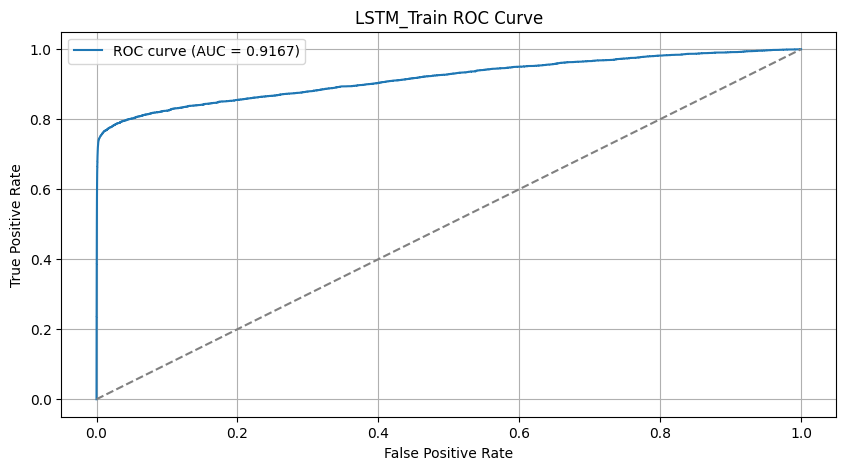

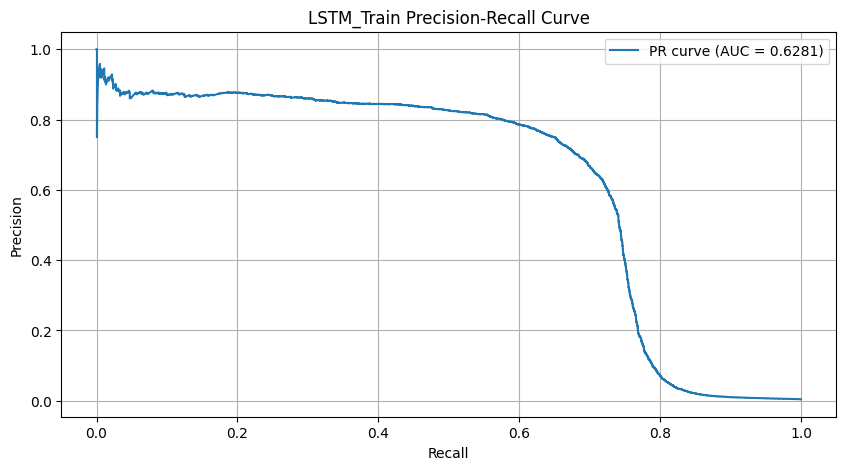


📊 LSTM_Test Metrics:
Accuracy     : 0.9956
Precision    : 0.5042
Recall       : 0.7168
F1 Score     : 0.5920
ROC AUC Score: 0.9098
Confusion Matrix:
[[263842    829]
 [   333    843]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9987    0.9969    0.9978    264671
           1     0.5042    0.7168    0.5920      1176

    accuracy                         0.9956    265847
   macro avg     0.7515    0.8569    0.7949    265847
weighted avg     0.9966    0.9956    0.9960    265847



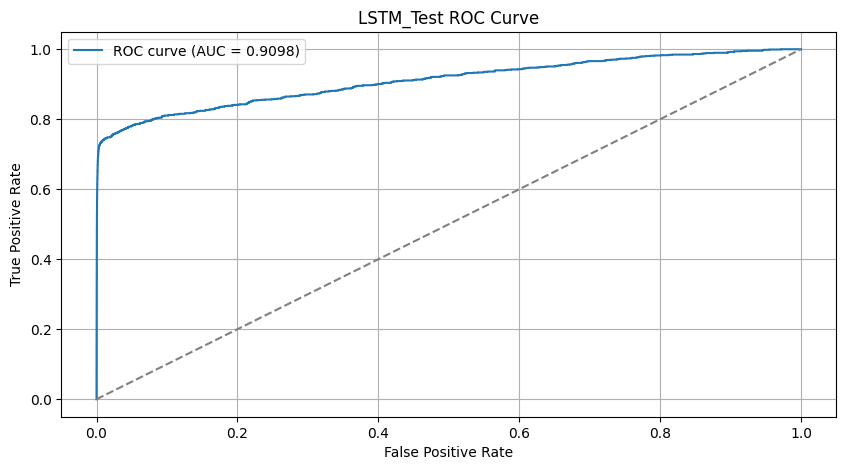

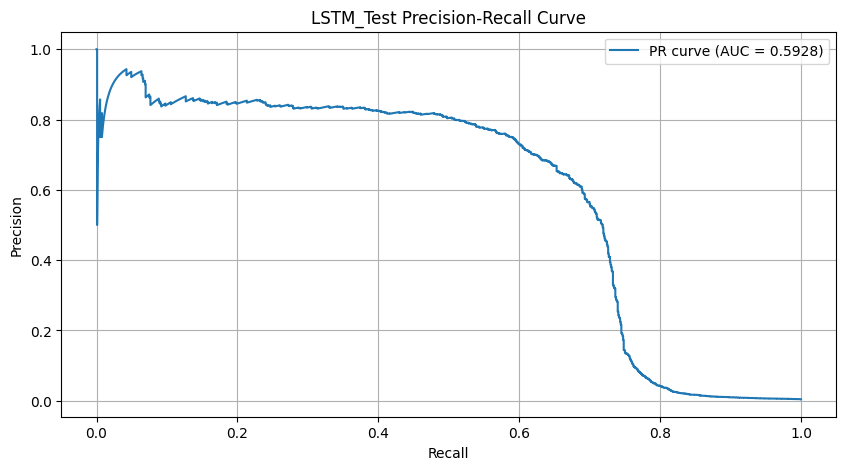

In [ ]:
# --- 10. Evaluation Function ---
def evaluate_model(y_true, y_pred, y_prob, name="Set"):
    print(f"\n📊 {name} Metrics:")
    print(f"Accuracy     : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision    : {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall       : {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score     : {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_prob):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_vals, precision_vals)
    plt.figure(figsize=(10, 5))
    plt.plot(recall_vals, precision_vals, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 11. Evaluate ---
evaluate_model(y_train, y_train_pred, y_train_prob, name="LSTM_Train")
evaluate_model(y_test, y_test_pred, y_test_prob, name="LSTM_Test")

In [ ]:
def focal_loss(gamma=4.0, alpha=0.0044):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma) * y_true + (1 - alpha) * tf.pow(y_pred, gamma) * (1 - y_true)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss)
    return loss

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Bidirectional, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

In [ ]:
class_weight = {0: 1., 1: 225.}  # based on your imbalance ratio

BiLSTM = Sequential([
    Input(shape=(sequence_length, len(features_for_sequence))),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32, return_sequences=True)),
    LSTM(16, return_sequences=False),
    Dense(1, activation='sigmoid')
])


BiLSTM.compile(
    optimizer='adam',
    loss=focal_loss(gamma=4.0, alpha=0.0044),
    metrics=['accuracy']
)

# === 4. Train Model ===
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('lstm_focal_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

BiLSTM.fit(
    X_seq_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=64,
    callbacks=[early_stop, checkpoint],
    class_weight=class_weight
)
# === 5. Save Final Model ===
BiLSTM.save('lstm_focal_final_model.keras', save_format='keras')

print("\n✅ Finished training with Focal Loss!")

Epoch 1/5
16613/16616 [============================>.] - ETA: 0s - loss: 1.3142e-04 - accuracy: 0.9956

ValueError: Data cardinality is ambiguous:
  x sizes: 529341
  y sizes: 265847
Make sure all arrays contain the same number of samples.

In [ ]:
# --- 9. Predict ---
y_train_prob = BiLSTM.predict(X_seq_train).flatten()
y_test_prob = BiLSTM.predict(X_seq_test).flatten()
y_train_pred = (y_train_prob > 0.5).astype(int)
y_test_pred = (y_test_prob > 0.5).astype(int)

8308/8308 [==============================] - 23s 3ms/step


In [ ]:
import matplotlib.pyplot as plt


📊 LSTM_Train Metrics:
Accuracy     : 0.9956
Precision    : 0.0000
Recall       : 0.0000
F1 Score     : 0.0000
ROC AUC Score: 0.9036
Confusion Matrix:
[[1058681       0]
 [   4706       0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9956    1.0000    0.9978   1058681
           1     0.0000    0.0000    0.0000      4706

    accuracy                         0.9956   1063387
   macro avg     0.4978    0.5000    0.4989   1063387
weighted avg     0.9912    0.9956    0.9934   1063387



/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

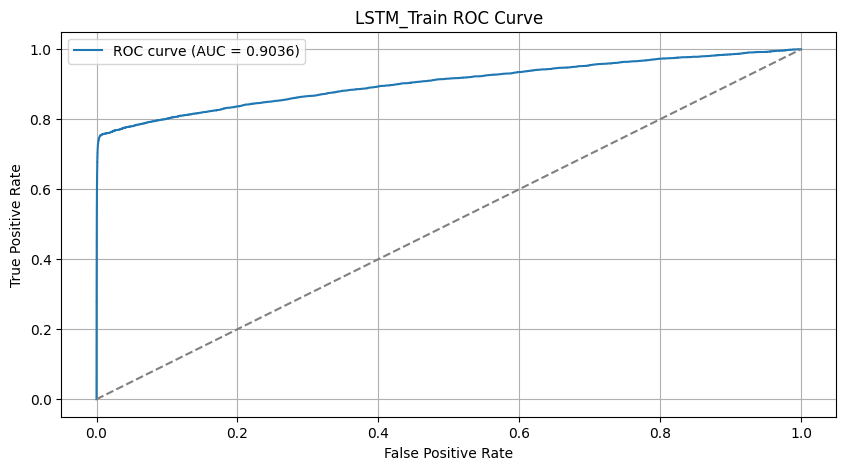

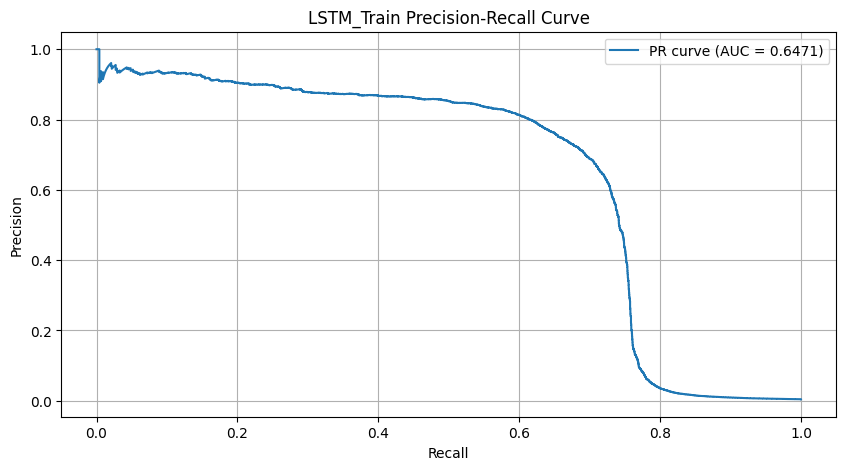


📊 LSTM_Test Metrics:
Accuracy     : 0.9956
Precision    : 0.0000
Recall       : 0.0000
F1 Score     : 0.0000
ROC AUC Score: 0.8899
Confusion Matrix:
[[264671      0]
 [  1176      0]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9956    1.0000    0.9978    264671
           1     0.0000    0.0000    0.0000      1176

    accuracy                         0.9956    265847
   macro avg     0.4978    0.5000    0.4989    265847
weighted avg     0.9912    0.9956    0.9934    265847



/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/naq/PycharmProjects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

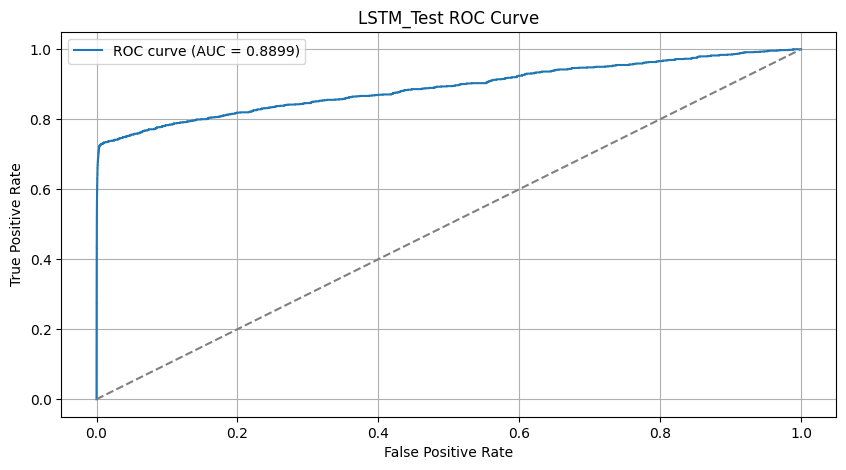

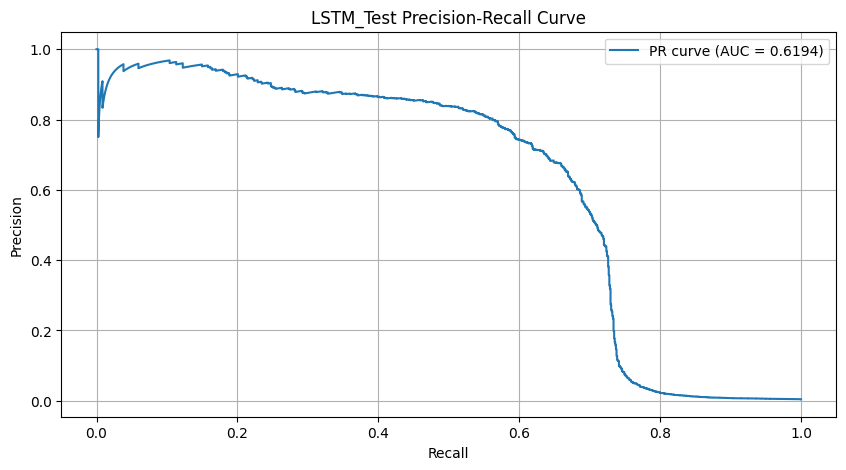

In [ ]:
# --- 10. Evaluation Function ---
def evaluate_model(y_true, y_pred, y_prob, name="Set"):
    print(f"\n📊 {name} Metrics:")
    print(f"Accuracy     : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision    : {precision_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"Recall       : {recall_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"F1 Score     : {f1_score(y_true, y_pred, zero_division=0):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_true, y_prob):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=4))

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 5))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_vals, precision_vals)
    plt.figure(figsize=(10, 5))
    plt.plot(recall_vals, precision_vals, label=f'PR curve (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 11. Evaluate ---
evaluate_model(y_train, y_train_pred, y_train_prob, name="LSTM_Train")
evaluate_model(y_test, y_test_pred, y_test_prob, name="LSTM_Test")

Only ML

In [ ]:
# Core Libraries
import numpy as np
import pandas as pd

# Machine Learning Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Selection
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Metrics and Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc
)

# Plotting
import matplotlib.pyplot as plt

# Imbalance Handling (if needed later)
from sklearn.utils import class_weight

# For RandomizedSearchCV distributions
from scipy.stats import uniform, randint

# Warning Control
import warnings
warnings.filterwarnings('ignore')


RF


📊 RandomForest_Train Metrics:
Accuracy     : 1.0000
Precision    : 1.0000
Recall       : 1.0000
F1 Score     : 1.0000
ROC AUC Score: 1.0000
Confusion Matrix:
[[1058681       0]
 [      0    4706]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000   1058681
           1     1.0000    1.0000    1.0000      4706

    accuracy                         1.0000   1063387
   macro avg     1.0000    1.0000    1.0000   1063387
weighted avg     1.0000    1.0000    1.0000   1063387



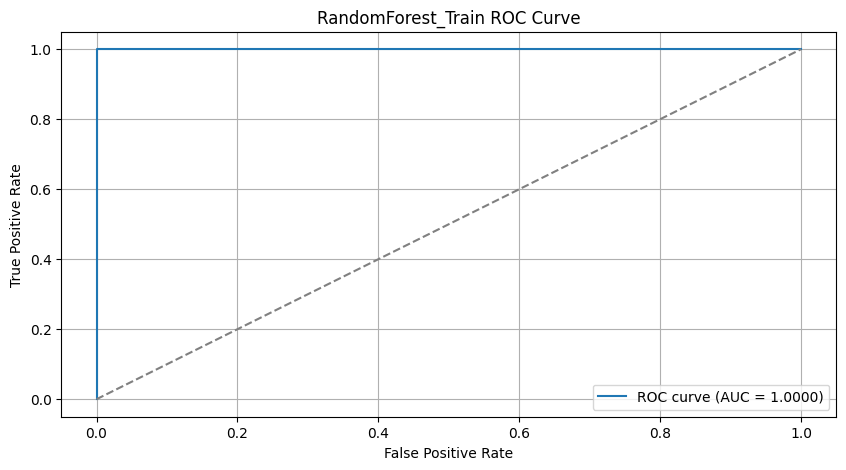

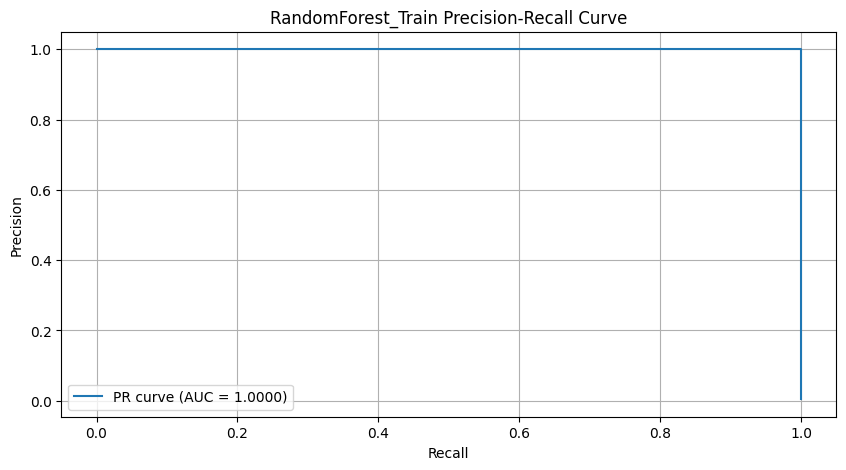


📊 RandomForest_Test Metrics:
Accuracy     : 0.9995
Precision    : 0.9392
Recall       : 0.9456
F1 Score     : 0.9424
ROC AUC Score: 0.9999
Confusion Matrix:
[[264599     72]
 [    64   1112]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9997    0.9997    264671
           1     0.9392    0.9456    0.9424      1176

    accuracy                         0.9995    265847
   macro avg     0.9695    0.9727    0.9711    265847
weighted avg     0.9995    0.9995    0.9995    265847



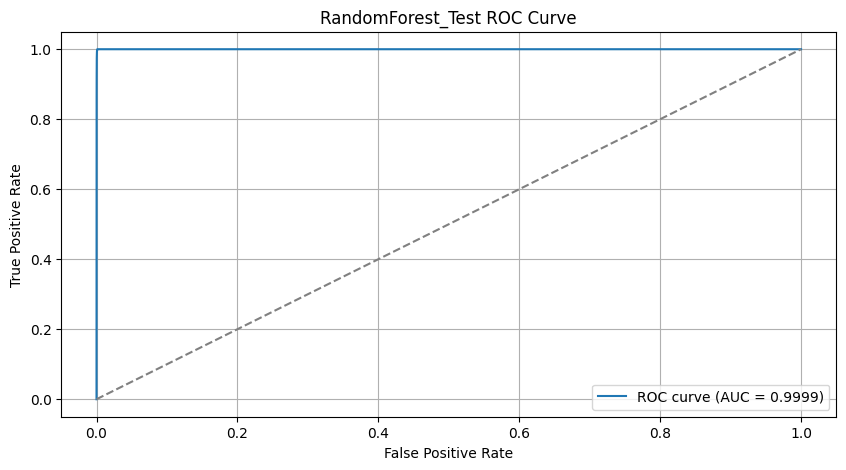

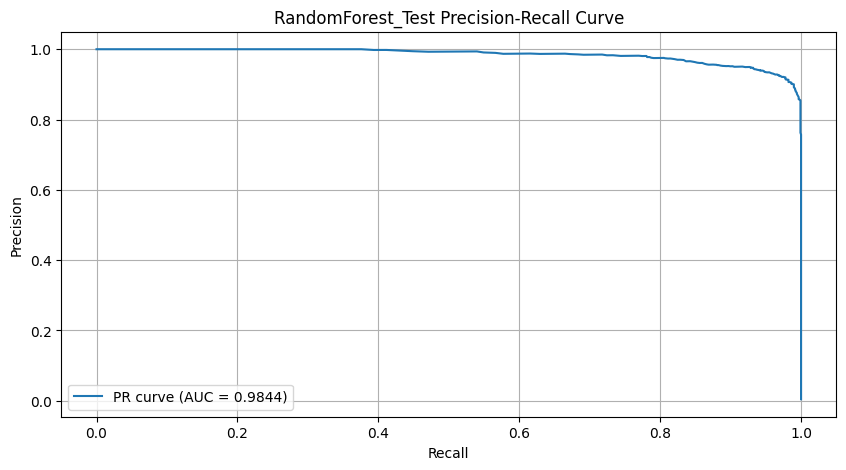

In [ ]:
# Define and train
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',  # handle imbalance
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_tab_train, y_train)

# Predict
y_train_pred = rf_model.predict(X_tab_train)
y_test_pred = rf_model.predict(X_tab_test)
y_train_prob = rf_model.predict_proba(X_tab_train)[:, 1]
y_test_prob = rf_model.predict_proba(X_tab_test)[:, 1]

# Evaluate
evaluate_model(y_train, y_train_pred, y_train_prob, name="RandomForest_Train")
evaluate_model(y_test, y_test_pred, y_test_prob, name="RandomForest_Test")


XGBoost


📊 XGBoost_Train Metrics:
Accuracy     : 0.9993
Precision    : 0.8555
Recall       : 1.0000
F1 Score     : 0.9221
ROC AUC Score: 1.0000
Confusion Matrix:
[[1057886     795]
 [      0    4706]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9992    0.9996   1058681
           1     0.8555    1.0000    0.9221      4706

    accuracy                         0.9993   1063387
   macro avg     0.9277    0.9996    0.9609   1063387
weighted avg     0.9994    0.9993    0.9993   1063387



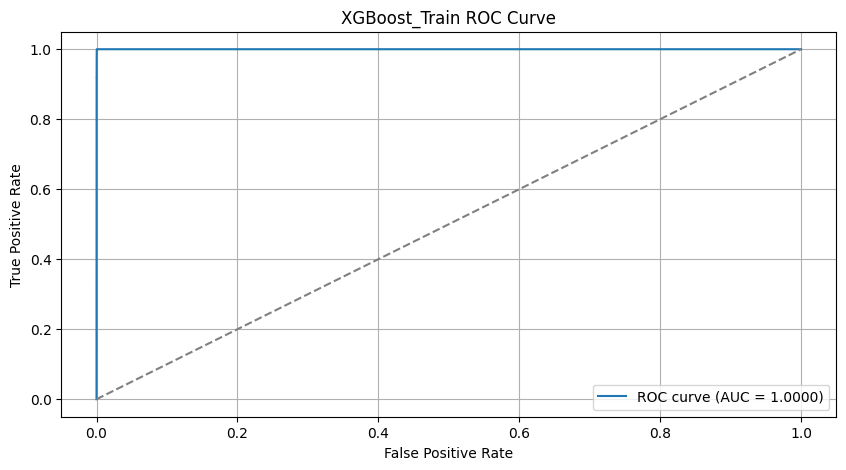

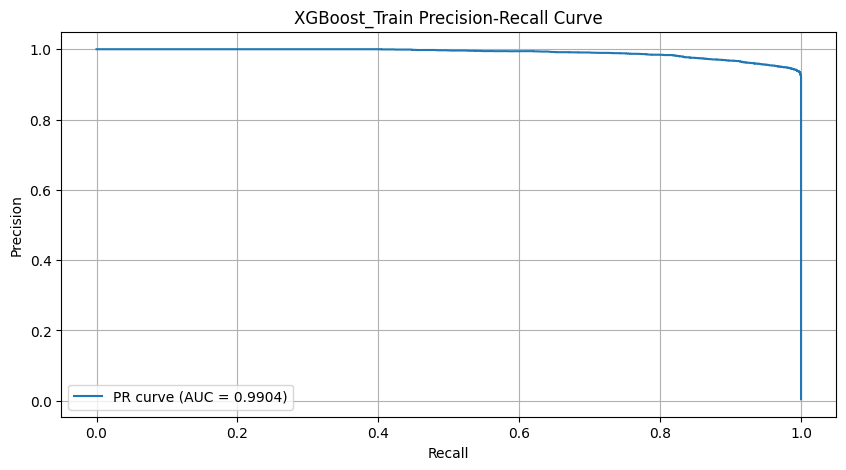


📊 XGBoost_Test Metrics:
Accuracy     : 0.9990
Precision    : 0.8216
Recall       : 0.9983
F1 Score     : 0.9013
ROC AUC Score: 0.9999
Confusion Matrix:
[[264416    255]
 [     2   1174]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9990    0.9995    264671
           1     0.8216    0.9983    0.9013      1176

    accuracy                         0.9990    265847
   macro avg     0.9108    0.9987    0.9504    265847
weighted avg     0.9992    0.9990    0.9991    265847



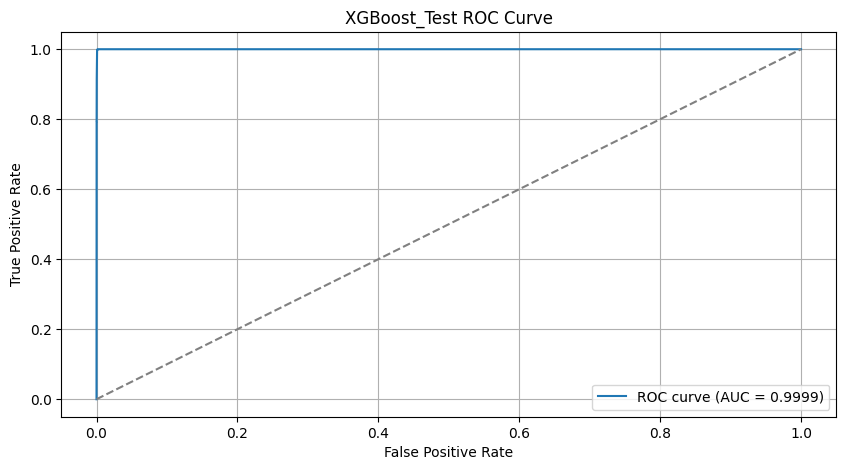

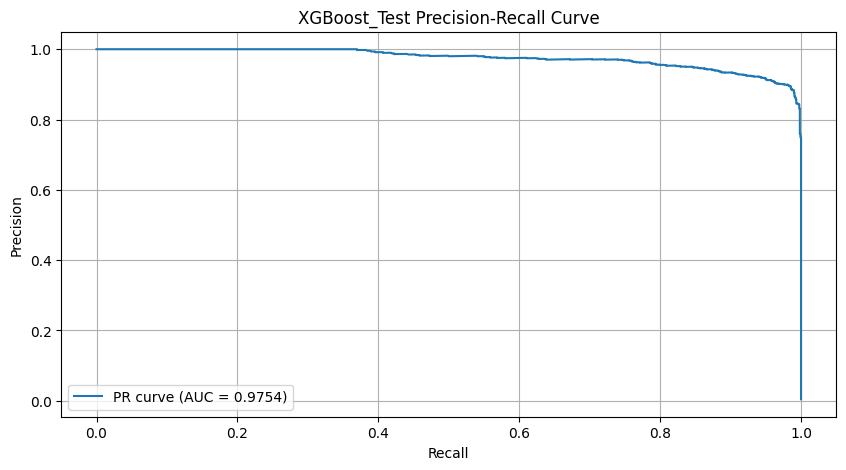

In [ ]:
# Define and train
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(), # handle imbalance
    random_state=42
)
xgb_model.fit(X_tab_train, y_train)

# Predict
y_train_pred = xgb_model.predict(X_tab_train)
y_test_pred = xgb_model.predict(X_tab_test)
y_train_prob = xgb_model.predict_proba(X_tab_train)[:, 1]
y_test_prob = xgb_model.predict_proba(X_tab_test)[:, 1]

# Evaluate
evaluate_model(y_train, y_train_pred, y_train_prob, name="XGBoost_Train")
evaluate_model(y_test, y_test_pred, y_test_prob, name="XGBoost_Test")


LightGBM

[LightGBM] [Info] Number of positive: 4706, number of negative: 1058681
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2073
[LightGBM] [Info] Number of data points in the train set: 1063387, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.004425 -> initscore=-5.415941
[LightGBM] [Info] Start training from score -5.415941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

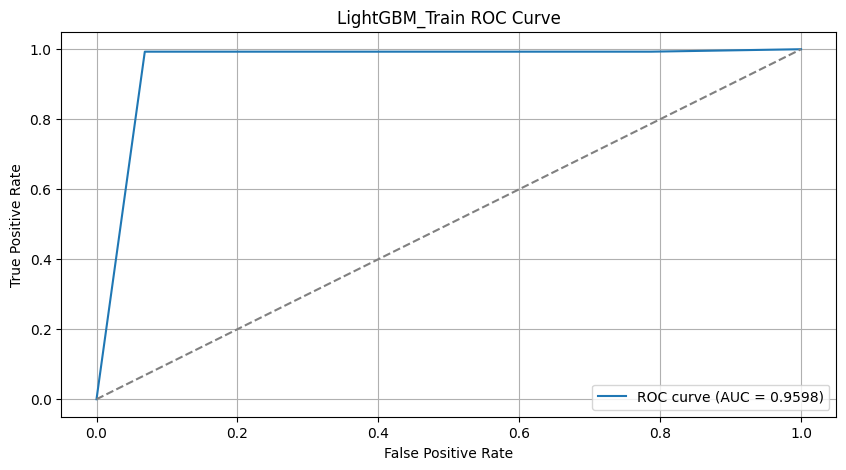

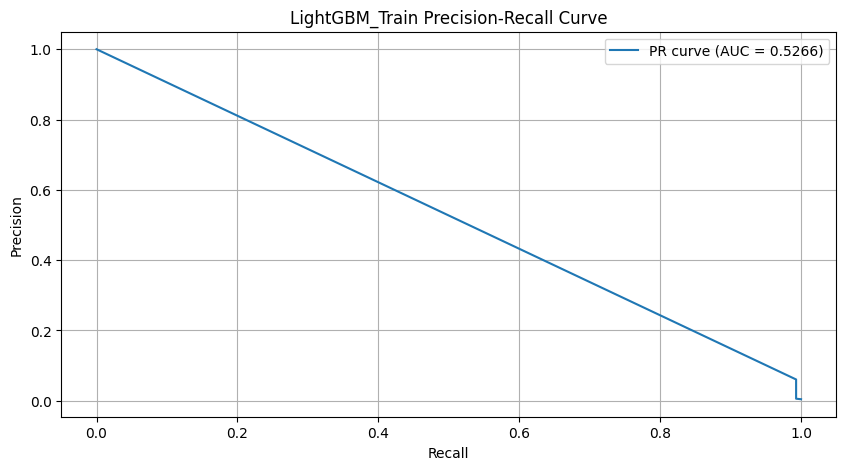


📊 LightGBM_Test Metrics:
Accuracy     : 0.9323
Precision    : 0.0607
Recall       : 0.9872
F1 Score     : 0.1143
ROC AUC Score: 0.9551
Confusion Matrix:
[[246701  17970]
 [    15   1161]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9999    0.9321    0.9648    264671
           1     0.0607    0.9872    0.1143      1176

    accuracy                         0.9323    265847
   macro avg     0.5303    0.9597    0.5396    265847
weighted avg     0.9958    0.9323    0.9611    265847



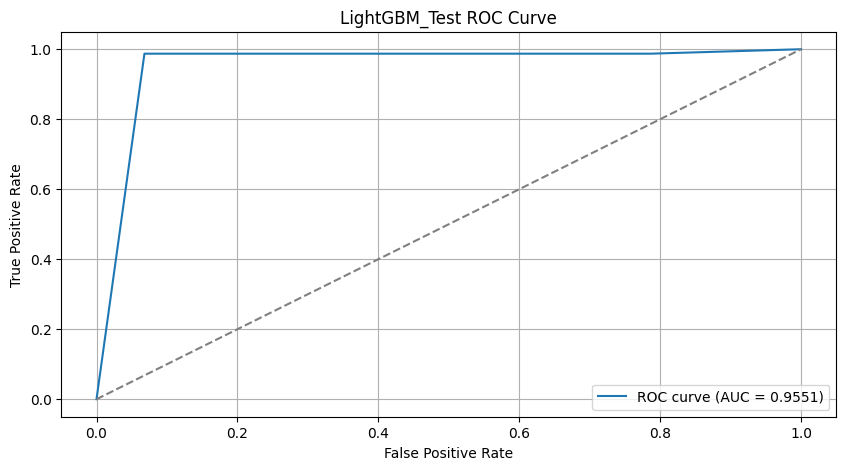

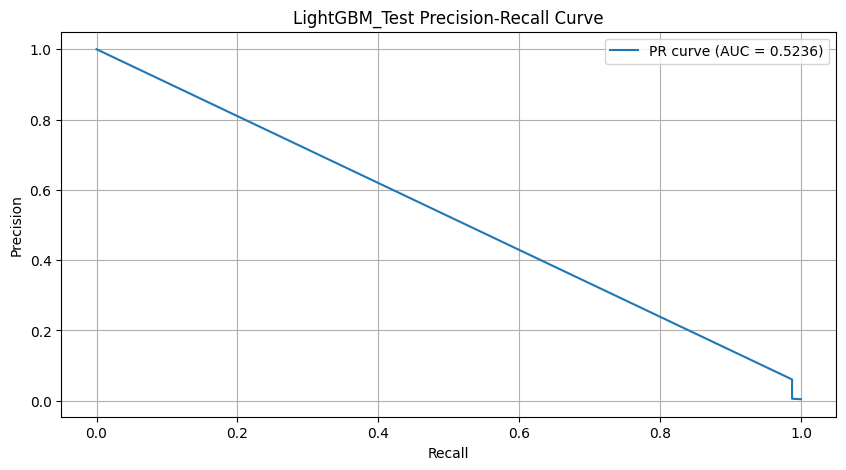

: 

In [ ]:
# Define and train
lgbm_model = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # handle imbalance
    random_state=42
)
lgbm_model.fit(X_tab_train, y_train)

# Predict
y_train_pred = lgbm_model.predict(X_tab_train)
y_test_pred = lgbm_model.predict(X_tab_test)
y_train_prob = lgbm_model.predict_proba(X_tab_train)[:, 1]
y_test_prob = lgbm_model.predict_proba(X_tab_test)[:, 1]

# Evaluate
evaluate_model(y_train, y_train_pred, y_train_prob, name="LightGBM_Train")
evaluate_model(y_test, y_test_pred, y_test_prob, name="LightGBM_Test")